# Data Attribute Recommendation - TechED 2020 INT260

Getting started with the Python SDK for the Data Attribute Recommendation service.

## Business Scenario

We will consider a business scenario involving product master data. The creation and maintenance of this product master data requires the careful manual selection of the correct categories for a given product from a pre-defined hierarchy of product categories.

In this workshop, we will explore how to automate this tedious manual task with the Data Attribute Recommendation service.

<video controls src="videos/dar_prediction_material_table.mp4"/>



This workshop will cover:
    
* Data Upload
* Model Training and Deployment
* Inference Requests
    
We will work through a basic example of how to achieve these tasks using the [Python SDK for Data Attribute Recommendation](https://github.com/SAP/data-attribute-recommendation-python-sdk).




*Note: if you are doing several runs of this notebook on a trial account, you may see errors stating 'The resource can no longer be used. Usage limit has been reached'. It can be beneficial to [clean up the service instance](#Cleaning-up-a-service-instance) to free up limited trial resources acquired by an earlier run of the notebook. [Some limits](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html) cannot be reset this way.*

## Table of Contents

* [Exercise 01.1](#Exercise-01.1) - Installing the SDK and preparing the service key
    * [Creating a service instance and key on BTP Trial](#Creating-a-service-instance-and-key)
    * [Installing the SDK](#Installing-the-SDK)
    * [Loading the service key into your Jupyter Notebook](#Loading-the-service-key-into-your-Jupyter-Notebook)
* [Exercise 01.2](#Exercise-01.2) - Uploading the data
* [Exercise 01.3](#Exercise-01.3) - Training the model
* [Exercise 01.4](#Exercise-01.4) - Deploying the Model and predicting labels
* [Resources](#Resources) - Additional reading
* [Cleaning up a service instance](#Cleaning-up-a-service-instance) - Clean up all resources on the service instance
* [Optional Exercises](#Optional-Exercises) - Optional exercises

## Requirements


See the [README in the Github repository for this workshop](https://github.com/SAP-samples/teched2020-INT260/blob/master/exercises/ex1-DAR/README.md).

# Exercise 01.1

*Back to [table of contents](#Table-of-Contents)*

In exercise 01.1, we will install the SDK and prepare the service key.

## Creating a service instance and key on BTP Trial

Please log in to your trial account: https://cockpit.eu10.hana.ondemand.com/trial/

In the your global account screen, go to the "Boosters" tab:

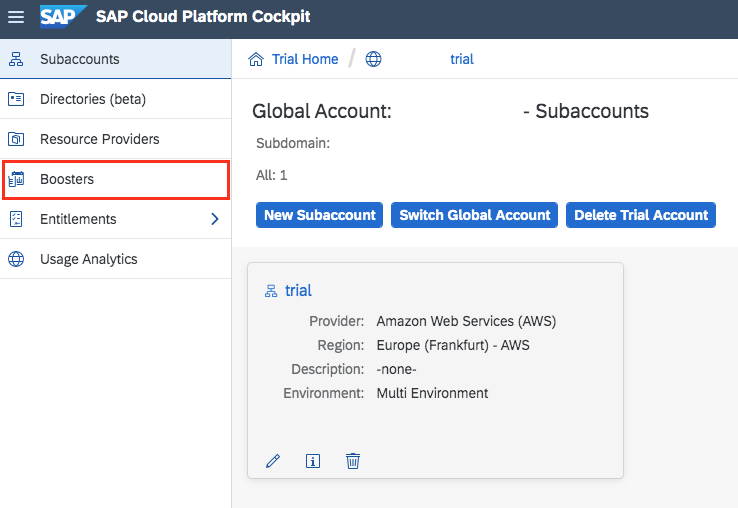

*Boosters are only available on the Trial landscape. If you are using a production environment, please follow this tutorial to manually [create a service instance and a service key](https://developers.sap.com/tutorials/cp-aibus-dar-service-instance.html)*.

In the Boosters tab, enter "Data Attribute Recommendation" into the search box. Then, select the
service tile from the search results: 
    
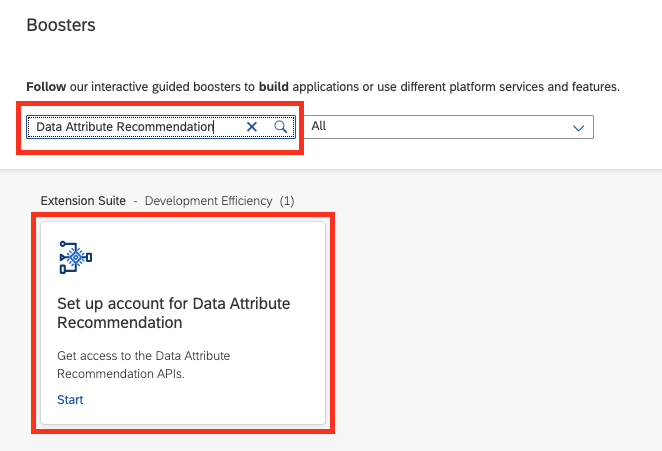

The resulting screen shows details of the booster pack. Here, click the "Start" button and wait a few seconds.

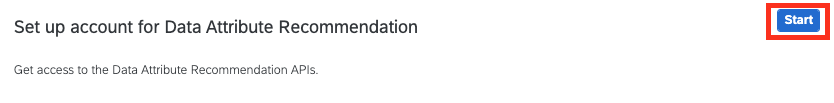

Once the booster is finished, click the "go to Service Key" link to obtain your service key.

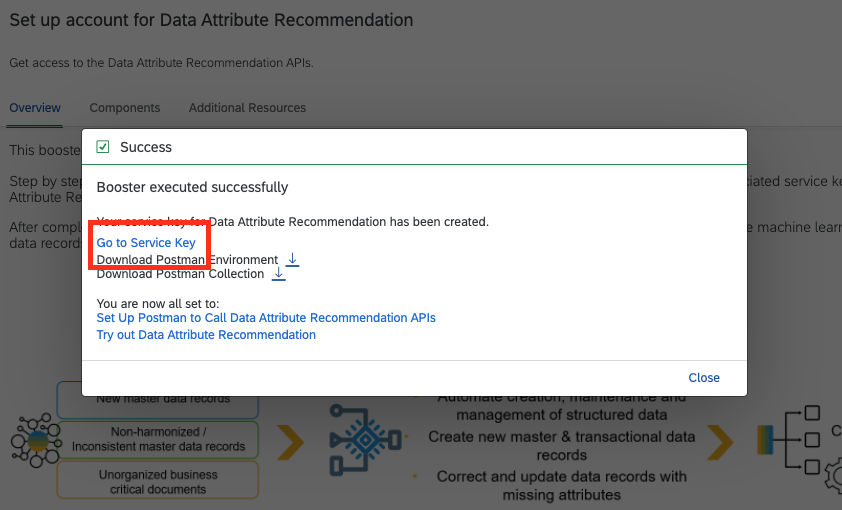

Finally, download the key and save it to disk.

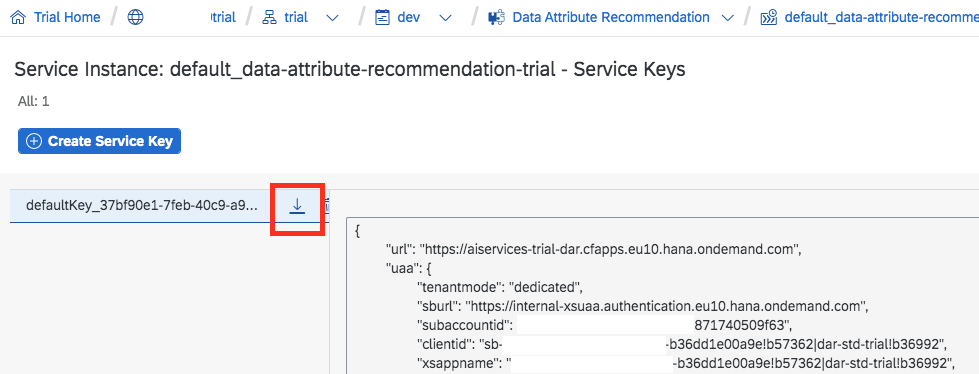

## Installing the SDK

The Data Attribute Recommendation SDK is available from the Python package repository. It can be installed with the standard `pip` tool:

In [ ]:
! pip install data-attribute-recommendation-sdk

*Note: If you are not using a Jupyter notebook, but instead a regular Python development environment, we recommend using a Python virtual environment to set up your development environment. Please see [the dedicated tutorial to learn how to install the SDK inside a Python virtual environment](https://developers.sap.com/tutorials/cp-aibus-dar-sdk-setup.html).*

## Loading the service key into your Jupyter Notebook

Once you downloaded the service key from the Cockpit, upload it to your notebook environment. The service key must be uploaded to same directory where the `teched2020-INT260_Data_Attribute_Recommendation.ipynb` is stored.

We first navigate to the file browser in Jupyter. On the top of your Jupyter notebook, right-click on the Jupyter logo and open in a new tab.

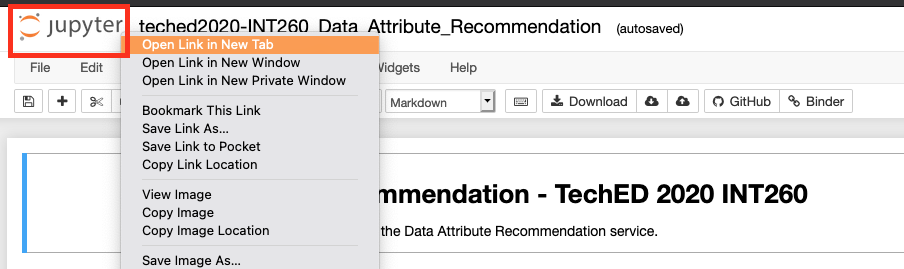

**In the file browser, navigate to the directory where the `teched2020-INT260_Data_Attribute_Recommendation.ipynb` notebook file is stored. The service key must reside next to this file.**

In the Jupyter file browser, click the **Upload** button (1). In the file selection dialog that opens, select the `defaultKey_*.json` file you downloaded previously from the SAP Cloud Platform Cockpit. Rename the file to `key.json`. 

Confirm the upload by clicking on the second **Upload** button (2).

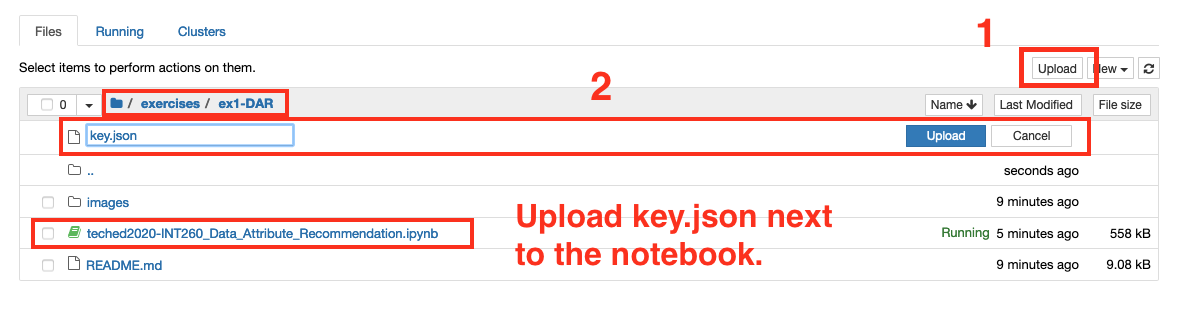

The service key contains your credentials to access the service. Please treat this as carefully as you would treat any password. We keep the service key as a separate file outside this notebook to avoid leaking the secret credentials.

The service key is a JSON file. We will load this file once and use the credentials throughout this workshop. 

In [1]:
# First, set up logging so we can see the actions performed by the SDK behind the scenes
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

from pprint import pprint # for nicer output formatting

In [2]:
import json
import os

if not os.path.exists("dar_key.json"):
    msg = "key.json is not found. Please follow instructions above to create a service key of"
    msg += " Data Attribute Recommendation. Then, upload it into the same directory where"
    msg += " this notebook is saved."
    print(msg)
    raise ValueError(msg)

with open("dar_key.json") as file_handle:
    key = file_handle.read()
    SERVICE_KEY = json.loads(key)

## Summary Exercise 01.1

In exercise 01.1, we have covered the following topics:

* How to install the Python SDK for Data Attribute Recommendation
* How to obtain a service key for the Data Attribute Recommendation service

# Exercise 01.2

*Back to [table of contents](#Table-of-Contents)*
*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.2, we will upload our demo dataset to the service.

## The Dataset

### Obtaining the Data

The dataset we use in this workshop is a CSV file containing product master data. The original data was released by BestBuy, a retail company, under [Creative Commons Zero v1.0 Universal](https://github.com/BestBuyAPIs/open-data-set/blob/master/LICENSE). This makes it ideal for first experiments with the Data Attribute Recommendation service.

The dataset can be downloaded directly from Github using the following command:

In [3]:
! wget -O bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"
# If you receive a "command not found" error (i.e. on Windows), try curl instead of wget:
# ! curl -o bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"

--2021-10-11 08:58:45--  https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9921374 (9.5M) [text/plain]
Saving to: ‘bestBuy.csv’

bestBuy.csv         100%[===================>]   9.46M  49.3MB/s    in 0.2s    

2021-10-11 08:58:45 (49.3 MB/s) - ‘bestBuy.csv’ saved [9921374/9921374]



Let's inspect the data:

In [4]:
# if you are experiencing an import error here, run the following in a new cell:
# ! pip install pandas
import pandas as pd

df = pd.read_csv("bestBuy.csv")
df.head(5)

,description,manufacturer,price,level1_category,level2_category,level3_category
0,Compatible with select electronic devices; AAA...,Duracell,5.49,Connected Home & Housewares,Housewares,Household Batteries
1,Long-lasting energy; DURALOCK Power Preserve t...,Duracell,5.49,Connected Home & Housewares,Housewares,Household Batteries
2,Compatible with select electronic devices; AA ...,Duracell,7.49,Connected Home & Housewares,Housewares,Household Batteries
3,4-pack AA alkaline batteries; battery tester i...,Energizer,4.99,Connected Home & Housewares,Housewares,Household Batteries
4,Compatible with select electronic devices; C s...,Duracell,8.99,Connected Home & Housewares,Housewares,Household Batteries


In [25]:
df.iloc[1]

description        Long-lasting energy; DURALOCK Power Preserve t...
manufacturer                                                Duracell
price                                                           5.49
level1_category                          Connected Home & Housewares
level2_category                                           Housewares
level3_category                                  Household Batteries
Name: 1, dtype: object

In [5]:
print()
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns.")


Data has 48087 rows and 6 columns.


The CSV contains the several products. For each product, the description, the manufacturer and the price are given. Additionally, three levels of the products hierarchy are given.

The first product, a set of AAA batteries, is located in the following place in the product hierarchy:

```
level1_category:         Connected Home & Housewares
                                      |
level2_category:                  Housewares
                                      |
level3_category:              Household Batteries
```

We will use the Data Attribute Recommendation service to predict the categories for a given product based on its **description**, **manufacturer** and **price**.

### Creating the DatasetSchema

We first have to describe the shape of our data by creating a DatasetSchema. This schema informs the service about the individual column types found in the CSV. We also describe which are the target columns used for training. These columns will be later predicted. In our case, these are the three category columns.

The service currently supports three column types: **text**, **category** and **number**. For prediction, only **category** is currently supported.

A DatasetSchema for the BestBuy dataset looks as follows:

```json
{
    "features": [
        {"label": "manufacturer", "type": "CATEGORY"},
        {"label": "description", "type": "TEXT"},
        {"label": "price", "type": "NUMBER"}
    ],
    "labels": [
        {"label": "level1_category", "type": "CATEGORY"},
        {"label": "level2_category", "type": "CATEGORY"},
        {"label": "level3_category", "type": "CATEGORY"}
    ],
    "name": "bestbuy-category-prediction",
}
```

We will now upload this DatasetSchema to the Data Attribute Recommendation service. The SDK provides the
[`DataManagerClient.create_dataset_schema()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset_schema) method for this purpose.


In [6]:
from sap.aibus.dar.client.data_manager_client import DataManagerClient

dataset_schema = {
    "features": [
        {"label": "manufacturer", "type": "CATEGORY"},
        {"label": "description", "type": "TEXT"},
        {"label": "level1_category", "type": "CATEGORY"},
        {"label": "level2_category", "type": "CATEGORY"},
        {"label": "level3_category", "type": "CATEGORY"}
        
    ],
    "labels": [
        {"label": "price", "type": "NUMBER"}
    ],
    "name": "bestbuy-price-prediction",
}


data_manager = DataManagerClient.construct_from_service_key(SERVICE_KEY)
response = data_manager.create_dataset_schema(dataset_schema)
dataset_schema_id = response["id"]

print()
print("DatasetSchema created:")

pprint(response)

print()
print(f"DatasetSchema ID: {dataset_schema_id}")

INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Creating DatasetSchema.
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Created DatasetSchema with ID 'ef1760b7-381e-4a14-8c0d-127015875c64'

DatasetSchema created:
{'createdAt': '2021-10-11T08:59:08.452632',
 'features': [{'label': 'manufacturer', 'type': 'CATEGORY'},
              {'label': 'description', 'type': 'TEXT'},
              {'label': 'level1_category', 'type': 'CATEGORY'},
              {'label': 'level2_category', 'type': 'CATEGORY'},
              {'label': 'level3_category', 'type': 'CATEGORY'}],
 'id': 'ef1760b7-381e-4a14-8c0d-127015875c64',
 'labels': [{'label': 'price', 'type': 'NUMBER'}],
 'name': 'bestbuy-price-prediction'}

DatasetSchema ID: ef1760b7-381e-4a14-8c0d-127015875c64


The API responds with the newly created DatasetSchema resource. The service assigned an ID to the schema. We save this ID in a variable, as we will need it when we upload the data.

### Uploading the Data to the service

The [`DataManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient) class is also responsible for uploading data to the service. This data must fit to an existing DatasetSchema. After uploading the data, the service will validate the Dataset against the DataSetSchema in a background process. The data must be a CSV file which can optionally be `gzip` compressed.

We will now upload our `bestBuy.csv` file, using the DatasetSchema which we created earlier.

Data upload is a two-step process. We first create the Dataset using [`DataManagerClient.create_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset). Then we can upload data to the Dataset using the [`DataManagerClient.upload_data_to_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_to_dataset) method.

In [7]:
dataset_resource = data_manager.create_dataset("my-bestbuy-dataset", dataset_schema_id)
dataset_id = dataset_resource["id"]

print()
print("Dataset created:")

pprint(dataset_resource)

print()
print(f"Dataset ID: {dataset_id}")

INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Creating Dataset with dataset_name 'my-bestbuy-dataset' and dataset_schema_id 'ef1760b7-381e-4a14-8c0d-127015875c64'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Created Dataset with ID '2280a210-86b4-4018-af22-ef5653e32677'

Dataset created:
{'createdAt': '2021-10-11T08:59:14.607007',
 'datasetSchemaId': 'ef1760b7-381e-4a14-8c0d-127015875c64',
 'id': '2280a210-86b4-4018-af22-ef5653e32677',
 'name': 'my-bestbuy-dataset',
 'status': 'NO_DATA',
 'validationMessage': ''}

Dataset ID: 2280a210-86b4-4018-af22-ef5653e32677


In [8]:
# Compress file first for a faster upload
! gzip -9 -c bestBuy.csv > bestBuy.csv.gz

Note that the data upload can take a few minutes. Please do not restart the process while the cell is still running.

In [9]:
# Open in binary mode.
with open('bestBuy.csv.gz', 'rb') as file_handle:
    dataset_resource = data_manager.upload_data_to_dataset(dataset_id, file_handle)

print()
print("Dataset after data upload:")
print()
pprint(dataset_resource)

INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Uploading data for dataset_id '2280a210-86b4-4018-af22-ef5653e32677'

Dataset after data upload:

{'createdAt': '2021-10-11T08:59:14.607007+00:00',
 'datasetSchemaId': 'ef1760b7-381e-4a14-8c0d-127015875c64',
 'id': '2280a210-86b4-4018-af22-ef5653e32677',
 'name': 'my-bestbuy-dataset',
 'status': 'VALIDATING',
 'validationMessage': ''}


Note that the Dataset status changed from `NO_DATA` to `VALIDATING`.

Dataset validation is a background process. The status will eventually change from `VALIDATING` to `SUCCEEDED`.
The SDK provides the [`DataManagerClient.wait_for_dataset_validation()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.wait_for_dataset_validation) method to poll for the Dataset validation.

In [10]:
dataset_resource = data_manager.wait_for_dataset_validation(dataset_id)

print()
print("Dataset after validation has finished:")

print()
pprint(dataset_resource)

INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Waiting for validation of Dataset ID '2280a210-86b4-4018-af22-ef5653e32677' to succeed!
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManagerClient:Polling status on Dataset ID '2280a210-86b4-4018-af22-ef5653e32677'
INFO:sap.aibus.dar.client.data_manager_client.DataManage

If the status is `FAILED` instead of `SUCCEEDED`, then the `validationMessage` will contain details about the validation failure.

To better understand the Dataset lifecycle, refer to the [corresponding document on help.sap.com](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/a9b7429687a04e769dbc7955c6c44265.html).

## Summary Exercise 01.2

In exercise 01.2, we have covered the following topics:

* How to create a DatasetSchema
* How to upload a Dataset to the service

You can find optional exercises related to exercise 01.2 [below](#Optional-Exercises-for-01.2).

# Exercise 01.3

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.3, we will train the model.

## Training the Model

The Dataset is now uploaded and has been validated successfully by the service.

To train a machine learning model, we first need to select the correct model template.

### Selecting the right ModelTemplate

The Data Attribute Recommendation service currently supports two different ModelTemplates:

| ID                                   | Name                  | Description                                                               |
|--------------------------------------|---------------------------|---------------------------------------------------------------------------|
| d7810207-ca31-4d4d-9b5a-841a644fd81f | **Hierarchical template** | Recommended for the prediction of multiple classes that form a hierarchy. |
| 223abe0f-3b52-446f-9273-f3ca39619d2c | **Generic template**      | Generic neural network for multi-label, multi-class classification.       |
| 188df8b2-795a-48c1-8297-37f37b25ea00 | **AutoML template**      | Finds the [best traditional machine learning model out of several traditional algorithms](https://blogs.sap.com/2021/04/28/how-does-automl-works-in-data-attribute-recommendation/). Single label only. |
| bdbcd699-4419-40a5-abb8-e7ad43dde49b | **Regression template**      | Predict the numeric value of a field. Single label only. |


We are building a model to predict the value of the product. The **Regression Template** is correct for this scenario. 

Refer to the [official documentation on ModelTemplates](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/1e76e8c636974a06967552c05d40e066.html) to learn more. Additional model templates may be added over time, so check back regularly.

## Starting the training

When working with models, we use the [`ModelManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient) class.

To start the training, we need the IDs of the dataset and the desired model template. We also have to provide a name for the model.
The [`ModelManagerClient.create_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.create_job) method launches the training Job.

*Only one model of a given name can exist. If you receive a message stating 'The model name specified is already in use', you either have to remove the job and its associated model first or you have to change the `model_name` variable name below. You can also [clean up the entire service instance](#Cleaning-up-a-service-instance).*

In [11]:
from sap.aibus.dar.client.model_manager_client import ModelManagerClient
from sap.aibus.dar.client.exceptions import DARHTTPException

model_manager = ModelManagerClient.construct_from_service_key(SERVICE_KEY)

In [12]:
model_template_collection = model_manager.read_model_template_collection()
pprint(model_template_collection)

{'count': 4,
 'modelTemplates': [{'autoML': False,
                     'createdAt': '2018-07-27T14:48:49.256490+00:00',
                     'description': 'Generic neural network for hierarchical '
                                    'classification. Number of inputs and '
                                    'outputs is derived from dataset schema.',
                     'id': 'd7810207-ca31-4d4d-9b5a-841a644fd81f',
                     'multiLabel': True,
                     'name': 'template-1',
                     'task': 'classification'},
                    {'autoML': False,
                     'createdAt': '2019-11-11T14:51:26.256490+00:00',
                     'description': 'Generic neural network for multi-label, '
                                    'multi-class classification. Number of '
                                    'inputs and outputs is derived from '
                                    'dataset schema.',
                     'id': '223abe0f-3b52-446f-9273-f

In [13]:
model_template_id = "bdbcd699-4419-40a5-abb8-e7ad43dde49b" # regression template
model_name = "bestbuy-regression-model"

job_resource = model_manager.create_job(model_name, dataset_id, model_template_id)
job_id = job_resource['id']

print()
print("Job resource:")
print()

pprint(job_resource)

print()
print(f"ID of submitted Job: {job_id}")

INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Creating job with model_name: bestbuy-regression-model, dataset_id: 2280a210-86b4-4018-af22-ef5653e32677, model_template_id: bdbcd699-4419-40a5-abb8-e7ad43dde49b
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Created job with id bed07c4d-2680-4f90-8466-e420ea5f53ea

Job resource:

{'datasetId': '2280a210-86b4-4018-af22-ef5653e32677',
 'endedAt': None,
 'id': 'bed07c4d-2680-4f90-8466-e420ea5f53ea',
 'maxTrainingTime': None,
 'message': None,
 'modelName': 'bestbuy-regression-model',
 'modelTemplateId': 'bdbcd699-4419-40a5-abb8-e7ad43dde49b',
 'progress': 0.0,
 'startedAt': None,
 'status': 'PENDING',
 'submittedAt': '2021-10-11T09:03:01+00:00'}

ID of submitted Job: bed07c4d-2680-4f90-8466-e420ea5f53ea


The job is now running in the background. Similar to the DatasetValidation, we have to poll the job until it succeeds.
The SDK provides the [`ModelManagerClient.wait_for_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_job) method:

In [14]:
job_resource = model_manager.wait_for_job(job_id)

print()

print("Job resource after training is finished:")

pprint(job_resource)

INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Waiting for job 'bed07c4d-2680-4f90-8466-e420ea5f53ea' to finish.
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Polling for status of job 'bed07c4d-2680-4f90-8466-e420ea5f53ea'
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Job 'bed07c4d-2680-4f90-8466-e420ea5f53ea': status 'SUCCEEDED', progress: '1.0'
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Job 'bed07c4d-2680-4f90-8466-e420ea5f53ea' has status: 'SUCCEEDED'

Job resource after training is finished:
{'datasetId': '2280a210-86b4-4018-af22-ef5653e32677',
 'endedAt': '2021-10-11T09:03:34+00:00',
 'id': 'bed07c4d-2680-4f90-8466-e420ea5f53ea',
 'maxTrainingTime': None,
 'message': None,
 'modelName': 'bestbuy-regression-model',
 'modelTemplateId': 'bdbcd699-4419-40a5-abb8-e7ad43dde49b',
 'progress': 1.0,
 'startedAt': '2021-10-11T09:03:01+00:00',
 'status': 'SUCCEEDED',
 'submittedAt': '2021-10-11T09:03:01+00:00'

To better understand the Training Job lifecycle, see the [corresponding document on help.sap.com](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/0fc40aa077ce4c708c1e5bfc875aa3be.html).

## Intermission

The model training will take between 5 and 10 minutes.

In the meantime, we can explore the available [resources](#Resources) for both the service and the SDK.

## Inspecting the Model

Once the training job is finished successfully, we can inspect the model using [`ModelManagerClient.read_model_by_name()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_model_by_name).


In [15]:
model_resource = model_manager.read_model_by_name(model_name)

print()
pprint(model_resource)


{'createdAt': '2021-10-11T09:03:34+00:00',
 'jobId': 'bed07c4d-2680-4f90-8466-e420ea5f53ea',
 'name': 'bestbuy-regression-model',
 'validationResult': {'meanAbsoluteError': 121.90316204896808,
                      'meanAbsolutePercentageError': 239.16607690449396,
                      'meanSquaredError': 129493.57427958571}}


In the model resource, the `validationResult` key provides information about model performance. You can also use these metrics to compare performance of different [ModelTemplates](#Selecting-the-right-ModelTemplate) or different datasets.

## Summary Exercise 01.3

In exercise 01.3, we have covered the following topics:

* How to select the appropriate ModelTemplate
* How to train a Model from a previously uploaded Dataset

You can find optional exercises related to exercise 01.3 [below](#Optional-Exercises-for-01.3).

# Exercise 01.4

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 01.4, we will deploy the model and predict labels for some unlabeled data.

## Deploying the Model

The training job has finished and the model is ready to be deployed. By deploying the model, we create a server process in the background on the Data Attribute Recommendation service which will serve inference requests.

In the SDK, the [`ModelManagerClient.create_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#module-sap.aibus.dar.client.model_manager_client) method lets us create a Deployment.


In [16]:
model_manager.read_model_collection()

{'count': 1,
 'models': [{'createdAt': '2021-10-11T09:03:34+00:00',
   'jobId': 'bed07c4d-2680-4f90-8466-e420ea5f53ea',
   'name': 'bestbuy-regression-model',
   'validationResult': {'meanAbsoluteError': 121.90316204896808,
    'meanAbsolutePercentageError': 239.16607690449396,
    'meanSquaredError': 129493.57427958571}}]}

In [17]:
model_manager.read_job_collection()

{'count': 2,
 'jobs': [{'datasetId': '2280a210-86b4-4018-af22-ef5653e32677',
   'endedAt': '2021-10-11T09:03:34+00:00',
   'id': 'bed07c4d-2680-4f90-8466-e420ea5f53ea',
   'maxTrainingTime': None,
   'message': None,
   'modelName': 'bestbuy-regression-model',
   'modelTemplateId': 'bdbcd699-4419-40a5-abb8-e7ad43dde49b',
   'progress': 1.0,
   'startedAt': '2021-10-11T09:03:01+00:00',
   'submittedAt': '2021-10-11T09:03:01+00:00'},
  {'datasetId': 'e0a13260-25fc-4bd4-b403-97c889a4158a',
   'endedAt': '2021-10-01T12:41:30+00:00',
   'id': 'e76d708b-bca2-435b-acc7-0d548077c0ff',
   'maxTrainingTime': None,
   'message': None,
   'modelName': 'product-hierarchy-model',
   'modelTemplateId': '223abe0f-3b52-446f-9273-f3ca39619d2c',
   'progress': 1.0,
   'startedAt': '2021-10-01T12:38:13+00:00',
   'submittedAt': '2021-10-01T12:36:57+00:00'}]}

In [18]:
model_manager.read_deployment_collection()

{'count': 0, 'deployments': []}

In [19]:
deployment_resource =  model_manager.create_deployment(model_name)
deployment_id = deployment_resource["id"]

print()
print("Deployment resource:")
print()

pprint(deployment_resource)

print(f"Deployment ID: {deployment_id}")

INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Creating Deployment for model_name 'bestbuy-regression-model'
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Created Deployment for model_name 'bestbuy-regression-model' with ID 'ms-4875711c-191c-4373-b3ac-9cc09baddb73'

Deployment resource:

{'deployedAt': None,
 'id': 'ms-4875711c-191c-4373-b3ac-9cc09baddb73',
 'modelName': 'bestbuy-regression-model',
 'status': 'PENDING'}
Deployment ID: ms-4875711c-191c-4373-b3ac-9cc09baddb73


*Note: if you are using a trial account and you see errors such as 'The resource can no longer be used. Usage limit has been reached', consider [cleaning up the service instance](#Cleaning-up-a-service-instance) to free up limited trial resources.*

Similar to the data upload and the training job, model deployment is an asynchronous process. We have to poll the API until the Deployment is in status `SUCCEEDED`. The SDK provides the [`ModelManagerClient.wait_for_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_deployment) for this purposes.

In [20]:
deployment_resource = model_manager.wait_for_deployment(deployment_id)

print()
print("Finished deployment resource:")
print()

pprint(deployment_resource)

INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Waiting for Deployment ID 'ms-4875711c-191c-4373-b3ac-9cc09baddb73' to succeed!
INFO:sap.aibus.dar.client.model_manager_client.ModelManagerClient:Deployment 'ms-4875711c-191c-4373-b3ac-9cc09baddb73' has status: SUCCEEDED

Finished deployment resource:

{'deployedAt': '2021-10-11T09:04:38.187000+00:00',
 'id': 'ms-4875711c-191c-4373-b3ac-9cc09baddb73',
 'modelName': 'bestbuy-regression-model',
 'status': 'SUCCEEDED'}


Once the Deployment is in status `SUCCEEDED`, we can run inference requests.

To better understand the Deployment lifecycle, see the [corresponding document on help.sap.com](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/f473b5b19a3b469e94c40eb27623b4f0.html).

*For trial users: the deployment will be stopped after 8 hours. You can restart it by deleting the deployment and creating a new one for your model. The [`ModelManagerClient.ensure_deployment_exists()`](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html) method will delete and re-create automatically. Then, you need to poll until the deployment is succeeded using [`ModelManagerClient.wait_for_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_deployment) as above.*

## Executing Inference requests

With a single inference request, we can send up to 50 objects to the service to predict the labels. The data send to the service must match the `features` section of the DatasetSchema created earlier. The `labels` defined inside of the DatasetSchema will be predicted for each object and returned as a response to the request.

In the SDK, the [`InferenceClient.create_inference_request()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.create_inference_request) method handles submission of inference requests.

In [24]:
from sap.aibus.dar.client.inference_client import InferenceClient

inference = InferenceClient.construct_from_service_key(SERVICE_KEY)

objects_to_be_classified = [
    {
        "features": [
            {"name": "manufacturer", "value": "Energizer"},
            {"name": "description", "value": "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"},
            {"name": "level1_category", "value":  "Connected Home & Housewares"},
            {"name": "level2_category", "value":  "Housewares"},
            {"name": "level3_category", "value":  "Household Batteries"}
        ],
    },
]

inference_response = inference.create_inference_request(model_name, objects_to_be_classified)

print()
print("Inference request processed. Response:")
print()
pprint(inference_response)


Inference request processed. Response:

{'id': '6ffdc549-ddd8-4238-5540-bd051ce686cf',
 'predictions': [{'labels': [{'name': 'price',
                              'results': [{'std': 21.0695533752,
                                           'value': '38.7287979126'}]}],
                  'objectId': None}],
 'processedTime': '2021-10-11T09:09:58.173358',
 'status': 'DONE'}


*Note: For trial accounts, you only have a limited number of objects which you can classify.*

You can also try to come up with your own example:

In [ ]:


my_own_items = [
    {
        "features": [
            {"name": "manufacturer", "value": "EDIT"},
            {"name": "description", "value": "EDIT"},
            {"name": "level1_category", "value":  "EDIT"},
            {"name": "level2_category", "value":  "EDIT"},
            {"name": "level3_category", "value":  "EDIT"}
        ],
    },
]

inference_response = inference.create_inference_request(model_name, my_own_items)

print()
print("Inference request processed. Response:")
print()
pprint(inference_response)

You can also classify multiple objects at once. For each object, the `top_n` parameter determines how many predictions are returned.

In [27]:
objects_to_be_classified = [
    {
        "objectId": "optional-identifier-1",
        "features": [
            {"name": "manufacturer", "value": "Duracell"},
            {"name": "description", "value": "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"},
            {"name": "level1_category", "value":  "Connected Home & Housewares"},
            {"name": "level2_category", "value":  "Housewares"},
            {"name": "level3_category", "value":  "Household Batteries"}
        ],
    },
    {
        "objectId": "optional-identifier-2",
        "features": [
            {"name": "manufacturer", "value": "Duracell"},
            {"name": "description", "value": "Long-lasting energy; DURALOCK Power Preserve"},
            {"name": "level1_category", "value":  "Connected Home & Housewares"},
            {"name": "level2_category", "value":  "Housewares"},
            {"name": "level3_category", "value":  "Household Batteries"}
        ],
    },
    {
        "objectId": "optional-identifier-3",
        "features": [
            {"name": "manufacturer", "value": "Energizer"},
            {"name": "description", "value": "4-pack AA alkaline batteries; battery tester"},
            {"name": "level1_category", "value":  "Connected Home & Housewares"},
            {"name": "level2_category", "value":  "Housewares"},
            {"name": "level3_category", "value":  "Household Batteries"}
        ],
    }
]


inference_response = inference.create_inference_request(model_name, objects_to_be_classified)

print()
print("Inference request processed. Response:")
print()
pprint(inference_response)


Inference request processed. Response:

{'id': '2708cbac-1a7b-448e-5dcb-258268dc44dc',
 'predictions': [{'labels': [{'name': 'price',
                              'results': [{'std': 22.5286827087,
                                           'value': '38.9666099548'}]}],
                  'objectId': 'optional-identifier-1'},
                 {'labels': [{'name': 'price',
                              'results': [{'std': 36.6737136841,
                                           'value': '74.2785491943'}]}],
                  'objectId': 'optional-identifier-2'},
                 {'labels': [{'name': 'price',
                              'results': [{'std': 36.1650314331,
                                           'value': '72.4449081421'}]}],
                  'objectId': 'optional-identifier-3'}],
 'processedTime': '2021-10-11T09:13:12.667572',
 'status': 'DONE'}


To learn how to execute inference calls without the SDK just using the underlying RESTful API, see [Inference without the SDK](#Inference-without-the-SDK).

## Summary Exercise 01.4

In exercise 01.4, we have covered the following topics:

* How to deploy a previously trained model
* How to execute inference requests against a deployed model

You can find optional exercises related to exercise 01.4 [below](#Optional-Exercises-for-01.4).

# Wrapping up

In this workshop, we looked into the following topics:

* Installation of the Python SDK for Data Attribute Recommendation
* Modelling data with a DatasetSchema
* Uploading data into a Dataset
* Training a model
* Predicting labels for unlabelled data

Using these tools, we are able to solve the problem of missing Master Data attributes starting from just a CSV file containing training data.

Feel free to revisit the workshop materials at any time. The [resources](#Resources) section below contains additional reading.

If you would like to explore the additional capabilities of the SDK, visit the [optional exercises](#Optional-Exercises) below.

## Cleanup

During the course of the workshop, we have created several resources on the Data Attribute Recommendation Service:

* DatasetSchema
* Dataset
* Job
* Model
* Deployment

The SDK provides several methods to delete these resources. Note that there are dependencies between objects: you cannot delete a Dataset without deleting the Model beforehand.

You will need to set `CLEANUP_SESSION = True` below to execute the cleanup.

In [ ]:
# Clean up all resources created earlier

CLEANUP_SESSION = True

def cleanup_session():
    model_manager.delete_deployment_by_id(deployment_id) # this can take a few seconds
    model_manager.delete_model_by_name(model_name)
    model_manager.delete_job_by_id(job_id)

    data_manager.delete_dataset_by_id(dataset_id)
    data_manager.delete_dataset_schema_by_id(dataset_schema_id)
    print("DONE cleaning up!")

if CLEANUP_SESSION:
    print("Cleaning up resources generated in this session.")
    cleanup_session()
else:
    print("Not cleaning up. Set 'CLEANUP_SESSION = True' above and run again!")

## Resources

*Back to [table of contents](#Table-of-Contents)*

### SDK Resources

* [SDK source code on Github](https://github.com/SAP/data-attribute-recommendation-python-sdk)
* [SDK documentation](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/)
* [How to obtain support](https://github.com/SAP/data-attribute-recommendation-python-sdk/blob/master/README.md#how-to-obtain-support)
* [Tutorials: Classify Data Records with the SDK for Data Attribute Recommendation](https://developers.sap.com/group.cp-aibus-data-attribute-sdk.html)

### Data Attribute Recommendation

* [SAP Help Portal](https://help.sap.com/viewer/product/Data_Attribute_Recommendation/SHIP/en-US)
* [API Reference](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/b45cf9b24fd042d082c16191aa938c8d.html)
* [Tutorials using Postman - interact with the service RESTful API directly](https://developers.sap.com/mission.cp-aibus-data-attribute.html)
* [Trial Account Limits](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html)
* [Metering and Pricing](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/1e093326a2764c298759fcb92c5b0500.html)


## Addendum

### Inference without the SDK

*Back to [table of contents](#Table-of-Contents)*

The Data Attribute Service exposes a RESTful API. The SDK we use in this workshop uses this API to interact with the DAR service.

For custom integration, you can implement your own client for the API. The tutorial "[Use Machine Learning to Classify Data Records]" is a great way to explore the Data Attribute Recommendation API with the Postman REST client. Beyond the tutorial, the [API Reference] is a comprehensive documentation of the RESTful interface.

[Use Machine Learning to Classify Data Records]: https://developers.sap.com/mission.cp-aibus-data-attribute.html

[API Reference]: https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/b45cf9b24fd042d082c16191aa938c8d.html

To demonstrate the underlying API, the next example uses the `curl` command line tool to perform an inference request against the Inference API.

The example uses the `jq` command to extract the credentials from the service. The authentication token is retrieved from the `uaa_url` and then used for the inference request.

In [ ]:
# If the following example gives you errors that the jq or curl commands cannot be found,
# you may be able to install them from conda by uncommenting one of the lines below:
#%conda install -q jq
#%conda install -q curl

In [ ]:
%%bash -s "$model_name" # Pass the python model_name variable as the first argument to shell script

model_name=$1

echo "Model: $model_name"

key=$(cat key.json)
url=$(echo $key | jq -r .url)
uaa_url=$(echo $key | jq -r .uaa.url)
clientid=$(echo $key | jq -r .uaa.clientid)
clientsecret=$(echo $key | jq -r .uaa.clientsecret)

echo "Service URL: $url"

token_url=${uaa_url}/oauth/token?grant_type=client_credentials

echo "Obtaining token with clientid $clientid from $token_url"

bearer_token=$(curl \
                --silent --show-error \
                --user $clientid:$clientsecret \
                $token_url \
                | jq -r .access_token
             )

inference_url=${url}/inference/api/v3/models/${model_name}/versions/1

echo "Running inference request against endpoint $inference_url"

echo ""

# We pass the token in the Authorization header.
# The payload for the inference request is passed as
# the body of the POST request below.
# The output of the curl command is piped through `jq`
# for pretty-printing
curl \
    --silent --show-error \
    --header "Authorization: Bearer ${bearer_token}" \
    --header "Content-Type: application/json" \
    -XPOST \
    ${inference_url} \
    -d '{
          "objects": [
            {
              "features": [
                {
                  "name": "manufacturer",
                  "value": "Energizer"
                },
                {
                  "name": "description",
                  "value": "Alkaline batteries; 1.5V"
                },
                {
                  "name": "price",
                  "value": "5.99"
                }
              ]
            }
          ]
        }' | jq

### Cleaning up a service instance

*Back to [table of contents](#Table-of-Contents)*

To clean all data on the service instance, you can run the following snippet. The code is self-contained and does not require you to execute any of the cells above. However, you will need to have the `key.json` containing a service key in place.

You will need to set `CLEANUP_EVERYTHING = True` below to execute the cleanup.

**NOTE: This will delete all data on the service instance!**

In [ ]:
CLEANUP_EVERYTHING = False

def cleanup_everything():
    import logging
    import sys

    logging.basicConfig(level=logging.INFO, stream=sys.stdout)

    import json
    import os

    if not os.path.exists("key.json"):
        msg = "key.json is not found. Please follow instructions above to create a service key of"
        msg += " Data Attribute Recommendation. Then, upload it into the same directory where"
        msg += " this notebook is saved."
        print(msg)
        raise ValueError(msg)

    with open("key.json") as file_handle:
        key = file_handle.read()
        SERVICE_KEY = json.loads(key)

    from sap.aibus.dar.client.model_manager_client import ModelManagerClient

    model_manager = ModelManagerClient.construct_from_service_key(SERVICE_KEY)

    for deployment in model_manager.read_deployment_collection()["deployments"]:
        model_manager.delete_deployment_by_id(deployment["id"])

    for model in model_manager.read_model_collection()["models"]:
        model_manager.delete_model_by_name(model["name"])

    for job in model_manager.read_job_collection()["jobs"]:
        model_manager.delete_job_by_id(job["id"])

    from sap.aibus.dar.client.data_manager_client import DataManagerClient

    data_manager = DataManagerClient.construct_from_service_key(SERVICE_KEY)

    for dataset in data_manager.read_dataset_collection()["datasets"]:
        data_manager.delete_dataset_by_id(dataset["id"])

    for dataset_schema in data_manager.read_dataset_schema_collection()["datasetSchemas"]:
        data_manager.delete_dataset_schema_by_id(dataset_schema["id"])
        
    print("Cleanup done!")

if CLEANUP_EVERYTHING:
    print("Cleaning up all resources in this service instance.")
    cleanup_everything()
else:
    print("Not cleaning up. Set 'CLEANUP_EVERYTHING = True' above and run again.")

### Optional Exercises

*Back to [table of contents](#Table-of-Contents)*

To work with the optional exercises, create a new cell in the Jupyter notebook by clicking the `+` button in the menu above or by using the `b` shortcut on your keyboard. You can then enter your code in the new cell and execute it.

#### Optional Exercises for 01.2

##### DatasetSchemas

Use the [`DataManagerClient.read_dataset_schema_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_schema_by_id) and the [`DataManagerClient.read_dataset_schema_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_schema_collection) methods to list the newly created and all DatasetSchemas, respectively.

##### Datasets

Use the [`DataManagerClient.read_dataset_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_by_id) and the [`DataManagerClient.read_dataset_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_collection) methods to inspect the newly created dataset.

Instead of using two separate methods to upload data and wait for validation to finish, you can also use [`DataManagerClient.upload_data_and_validate()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_and_validate).

#### Optional Exercises for 01.3

##### ModelTemplates

Use the [`ModelManagerClient.read_model_template_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_model_template_collection) to list all existing model templates.

##### Jobs

Use [`ModelManagerClient.read_job_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_by_id) and [`ModelManagerClient.read_job_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_collection) to inspect the job we just created.

The entire process of uploading the data and starting the training is also available as a single method call in [`ModelCreator.create()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.workflow.model.ModelCreator.create).

#### Optional Exercises for 01.4

##### Deployments

Use [`ModelManagerClient.read_deployment_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_by_id) and [`ModelManagerClient.read_deployment_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_collection) to inspect the Deployment.

Use the [`ModelManagerclient.lookup_deployment_id_by_model_name()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.lookup_deployment_id_by_model_name) method to find the deployment ID for a given model name.

##### Inference

Use the [`InferenceClient.do_bulk_inference()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.do_bulk_inference) method to process more than fifty objects at a time. Note how the data format returned changes.